### Naive Bayes & Linear Gaussian Model for 

In [152]:
import numpy as np 
import math


#### Auxiliary functions

In [153]:
# Skeleton definition
NUI_SKELETON_POSITION_COUNT = 20

NONE = -1
HIP_CENTER = 0
SPINE = 1
SHOULDER_CENTER = 2
HEAD = 3
SHOULDER_LEFT = 4
ELBOW_LEFT = 5
WRIST_LEFT = 6
HAND_LEFT = 7
SHOULDER_RIGHT = 8
ELBOW_RIGHT = 9
WRIST_RIGHT = 10
HAND_RIGHT = 11
HIP_LEFT = 12
KNEE_LEFT = 13
ANKLE_LEFT = 14
FOOT_LEFT = 15
HIP_RIGHT = 16
KNEE_RIGHT = 17
ANKLE_RIGHT = 18
FOOT_RIGHT = 19

nui_skeleton_names = ( \
    'HIP_CENTER', 'SPINE', 'SHOULDER_CENTER', 'HEAD', \
    'SHOULDER_LEFT', 'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', \
    'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT', \
    'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT', 'FOOT_LEFT', \
    'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT' )

nui_skeleton_conn = ( \
    NONE, \
    HIP_CENTER, \
    SPINE, \
    SHOULDER_CENTER, \
    # Left arm 
    SHOULDER_CENTER, \
    SHOULDER_LEFT,  \
    ELBOW_LEFT,  \
    WRIST_LEFT,  \
    # Right arm 
    SHOULDER_CENTER,  \
    SHOULDER_RIGHT,  \
    ELBOW_RIGHT,  \
    WRIST_RIGHT,  \
    # Left leg 
    HIP_CENTER,  \
    HIP_LEFT,  \
    KNEE_LEFT,  \
    ANKLE_LEFT,  \
    # Right leg 
    HIP_CENTER,  \
    HIP_RIGHT,  \
    KNEE_RIGHT,  \
    ANKLE_RIGHT,  \
)


In [154]:
log_c=0

In [155]:
def load_dataset(file=None):
    """
      Returns the data, the labels and the person id for each action
    """
    import scipy.io
    
    if file is None:
        ex = scipy.io.loadmat('data/data.mat')
    else:
        ex = scipy.io.loadmat(file)
    
    return ex['data'],ex['labels'],ex['individuals']
    

In [156]:
def load_dataset_val(file=None):
    """
      Loads Validation data.
      Returns the data, the labels and the person id for each action
    """
    import scipy.io
    
    if file is None:
        ex = scipy.io.loadmat('data/validation_data.mat')
    else:
        ex = scipy.io.loadmat(file)
    
    return ex['data_small'],ex['labels_small'],ex['individuals_small']
    

In [157]:
def log_normpdf(x, mu, sigma):
    
    pdf=((-0.5*np.log(2*np.pi*sigma))-(pow((x-mu),2)/(2*sigma))) 
    
    """
      Computes the natural logarithm of the normal probability density function
      
    """
    return pdf


In [158]:
def normalize_logprobs(log_probs):
    """
       Returns the log prob normalizes so that when exponenciated
       it adds up to 1 (Useful to normalizes logprobs)
    """ 
    b = log_probs.max()
    y = np.exp(log_probs - b)
    return y / y.sum()


In [159]:
def calculatePrior(labels):
    '''
    Calculates the Prior Probability.
    '''
    unique, counts = np.unique(labels, return_counts=True)
    priorProb=counts/labels.size;
    return priorProb
    

In [160]:
def EdYx(Y,X):
    '''Helper function to multiply and sum up two vectors (Expected Values)'''
    return np.mean(Y*X)


#### Function for encoding the Labels 

In [221]:
def label_encode(r):
    
    index = np.argmax(r, axis=0)

    if index==0:
        pred=1
    elif(index==1):
        pred=2
    elif(index==2):
        pred=3
    elif(index==3):
        pred=8
    else:
        raise ValueError('Index is not correct')
    
    return pred

#### Functions to implement

In [162]:
def fit_gaussian(X, W=None):
    
    mean=np.mean(X)
    variance=np.var(X)
    
    """
      Compute the mean and variance of X, 
      You can ignore W for the moment
    """
    return (mean, variance)


In [163]:
def my_cov(x,y,w=None):
    """
      Useful function for fit_linear_gaussian
    """
    #cov=EdYx(x,y)-np.mean(x)*np.mean(y)
    cov=np.sum(w*x*y)/np.sum(w)-np.sum(w*x)*np.sum(w*y)/np.sum(w)/np.sum(w)

    return cov

#### Calculate Betas and Sigma for LGM model 

In [164]:
def fit_linear_gaussian(Y,X,W = None):
    """
    Input:
      Y: vector of size D with the observations for the variable
      X: matrix DxV with the observations for the parent variables
                 of X. V is the number of parent variables
      W: vector of size D with the weights of the instances (ignore for the moment)
      
    Outout:
       The betas and sigma
    """
    
    # Create Vector B for expected values of observed variables 
    B=[]
    B.append(np.mean(Y))
    
    for i in range (X.shape[1]):
        B.append(EdYx(Y,X[:,i]))
    B=np.array(B)
    
    #Create Matrix A for expected values of the parents
    A = np.zeros(shape=(4, 4), dtype=float)
    A[0][0]=1
    for i in range (1,A.shape[1]):
        A[i][0]=np.mean(X[:,i-1])
        A[0][i]=np.mean(X[:,i-1])

    for i in range (1,A.shape[1]):
        for j in range(1,A.shape[1]):     
            A[i][j]=EdYx(X[:,i-1],X[:,j-1])
    
    
    #Calculate the betas
    betas = np.linalg.solve(A,B)
    
    temp=0
    #create vector containing ones for weights
    w=np.ones(shape=(X.shape[0]))
   
    # Calculate sigmas
    for i in range (1,X.shape[1]+1):
        for j in range(1,X.shape[1]+1):     
            temp=temp+(betas[i]*betas[j]*my_cov(X[:,i-1],X[:,j-1],w))
        
    cov= my_cov(Y,Y,w)
    sigma= np.sqrt(cov-temp)                                                       
                                                                                
    if sigma == 0 or type(sigma) == 'complex':                                   
        sigma = .01                                                              
    else:                                                                        
        sigma = sigma + .01                                                      
                                                                                
    sigma = sigma**2                                                                                                                                         
    
    return (betas,sigma)

#### Function to Check the fit_linear_gaussian Implementation

In [165]:
def generate_random_lgm_samples(n, betas, sigma):
    """Function to generate random samples for a 
       Linear Gaussian Model
       Input:
           n: Number of samples
           betas: vector with the values the the betas from 0 to k
           sigma: standard deviation
    """
    X = np.random.randn(n,betas.shape[0]-1)
    Y = np.random.randn(n)*sigma + np.sum(X*betas[1:],axis=1)+betas[0]
    return X,Y

betas = np.array([10,12,4,16])
sigma = 0.1
n=10
X,Y=generate_random_lgm_samples(n,betas,sigma)
# This following call should output  betas and sigma close to the above ones

betas, sigma=fit_linear_gaussian(Y,X)
print('Output betas From fit_linear_gaussian function',betas)
print('Output sigma From fit_linear_gaussian function',sigma)


Output betas From fit_linear_gaussian function [10.05948322 12.02037086  3.96332739 15.99609114]
Output sigma From fit_linear_gaussian function 0.009760894687608095


 #### Function for insolating the individual Class

In [166]:
def isolate_classes(data,label):


    idx=[]
    #checks the number of unique class in the dataset and Creates index lists for different classes
    for c in np.unique(label):
        idx.append(np.where(label==c))

    c1=np.zeros((data.shape[0],data.shape[1],len(idx[0][0])))
    for i in range (len(idx[0][0])):
        c1[:,:,i]=data[:,:,idx[0][0][i]]


    c2=np.zeros((data.shape[0],data.shape[1],len(idx[1][0])))
    for i in range (len(idx[1][0])):
        c2[:,:,i]=data[:,:,idx[1][0][i]]

    c3=np.zeros((data.shape[0],data.shape[1],len(idx[2][0])))
    for i in range (len(idx[2][0])):
        c3[:,:,i]=data[:,:,idx[2][0][i]]

    c4=np.zeros((data.shape[0],data.shape[1],len(idx[3][0])))
    for i in range (len(idx[3][0])):
        c4[:,:,i]=data[:,:,idx[3][0][i]]

    #returns the list of classes
    class_list=[c1,c2,c3,c4]

    return class_list

 #### Class for LGM model

In [167]:
class model_lgm:
    def __init__(self,graph):
        self.data=data
        self.label=label
        self.graph=graph
        self.class_priors=None
        self.jointparts_mean=None
        self.jointparts_var=None
        self.jointparts_betas=None
    
    def train(self,data,label):
        #Calculate Class prior
        self.class_priors= calculatePrior(label)
        #Isolate the classes 
        all_class= isolate_classes(data,label)

        #Declare necessary matrices for lgm model 
        self.jointparts_mean=np.zeros(shape=(data.shape[0]-19,data.shape[1],len(all_class)))
        self.jointparts_betas=np.zeros(shape=(data.shape[0],data.shape[1],data.shape[1]+1,len(all_class)))
        self.jointparts_var=np.zeros(shape=(data.shape[0],data.shape[1],len(all_class)))

        '''
        Each class has the shape Joint*Dimension*#instances belong to that class.
        Following loop iterates over each class , each joint and each dimension(x,y,z)
        and Computes betas and sigma.
        
        ***PLEASE NOTE THAT FIRST POSITION OF JOINTPART_BETAS MATRIX IS EMPTY DUE TO NOT HAVING PARENT FOT
        *** 1ST JOINT.
        '''
        for c in range(len(all_class)):
            cl=all_class[c]
            for i in range (cl.shape[1]):
                self.jointparts_mean[0,i,c],self.jointparts_var[0,i,c]=fit_gaussian(cl[0,i,:])
                for j in range(cl.shape[0]-1):
                    Y=cl[j+1,i,:].transpose()
                    X=cl[nui_skeleton_conn[j+1],:,:].transpose()
                    self.jointparts_betas[j+1,i,c],self.jointparts_var[j+1][i][c]=fit_linear_gaussian(Y,X)
    
    
    def predict(self,data):
        y_pred=[]
        for i in range(data.shape[2]):
            pp=self.compute_logprobs(data[:,:,i])+np.log(self.class_priors)
            r=normalize_logprobs(pp)
            y_pred.append(label_encode(r))
        y_pred=np.array(y_pred)
        return y_pred

    
    
    def compute_logprobs(self,instance):
    
        '''
        Each instance has the shape of Joint*Dimension.
        Following loop iterates over each class , each joint and each dimension(x,y,z)
        and calculate log likelihood for each class of the instance.
        
        
        '''
        likelihood=[]
        

        ci=0
        for c in range (self.jointparts_var.shape[2]):
            temp=0
            for j in range (self.jointparts_var.shape[1]):
                temp=temp+log_normpdf(instance[0,j],self.jointparts_mean[0,j,c],self.jointparts_var[0,j,c])        
                for i in range (1,self.jointparts_var.shape[0]):
                    mn=sum(self.jointparts_betas[i,j,c,1:4]*instance[self.graph[i],:] )+self.jointparts_betas[i,j,c,0]                   
                    temp=temp+log_normpdf(instance[i][j],mn,self.jointparts_var[i][j][c])
            likelihood.append(temp)
        return likelihood


 #### Class for NB model

In [168]:
class model_nb:
    def __init__(self):
        self.class_priors=None
        jointparts_mean=None
        jointparts_var=None
    
    
    
    
    def train(self,data,label):
        
        all_class= isolate_classes(data,label)
        self.jointparts_mean=np.zeros(shape=(data.shape[0],data.shape[1],len(all_class)))
        self.jointparts_var=np.zeros(shape=(data.shape[0],data.shape[1],len(all_class)))
        self.class_priors=calculatePrior(label)
        
        '''
        Each class has the shape Joint*Dimension*#instances belong to that class.
        Following loop iterates over each class , each joint and each dimension(x,y,z)
        and Computes betas and sigma.
        '''
        for c in range(len(all_class)):
            cl=all_class[c]
            for j in range (cl.shape[0]):
                for i in range(cl.shape[1]):
                    self.jointparts_mean[j,i,c],self.jointparts_var[j,i,c]=fit_gaussian(cl[j,i,:])
    
    def predict(self,data):
        y_pred=[]
        for i in range(data.shape[2]):
            pp=self.compute_logprobs(data[:,:,i])+np.log(self.class_priors)
            r=normalize_logprobs(pp)
            y_pred.append(label_encode(r))
        y_pred=np.array(y_pred)
        return y_pred
    
    def compute_logprobs(self,instance):

        '''
        Each instance has the shape of Joint*Dimension.
        Following loop iterates over each class , each joint and each dimension(x,y,z)
        and calculate log likelihood for each class of the instance.
        '''
        likelihood=[]
        for c in range (self.jointparts_mean.shape[2]):
            temp=0
            for j in range (self.jointparts_mean.shape[1]):
                for i in range (self.jointparts_mean.shape[0]):        
                    temp=temp+log_normpdf(instance[i][j],self.jointparts_mean[i][j][c],self.jointparts_var[i][j][c])
            likelihood.append(temp)

        return likelihood


### Learn Appropiate model Depending on graph supplied or not 

In [169]:
def learn_model(dataset, labels, G=None):
    if G is not None:
        classifier=model_lgm(G)
        classifier.train(dataset,labels)
    else:
        classifier=model_nb()
        classifier.train(dataset,labels)
    return classifier

### Utility Function to Generate Result 

#### Function for calculating the accuracy

In [171]:
def calculateAccuracy(prediction,groundTruth):
    acc=sum(prediction==groundTruth[:,0])
    acc=acc/len(prediction)*100
    return acc


#### Function for Cross validation

In [172]:
def cv(model,data,label,fold):
    from sklearn.model_selection import KFold
    import matplotlib.pyplot as plt
    data=data.transpose()
    data=data
    kf = KFold(n_splits=fold,shuffle=True)
    accuracy=[]
    k=0
    for train_index, test_index in kf.split(data):
        data_train, data_test = data[train_index], data[test_index]   
        label_train, label_test = label[train_index], label[test_index]
        data_train=data_train.transpose()
        data_test=data_test.transpose()
        model.train(data_train,label_train)
        pred=model.predict(data_test)
        acc=calculateAccuracy(pred,label_test)
        accuracy.append(acc)
        k+=1
        print("Fold:",(k) ," Accuracy:",acc)
    avg_accuracy=np.mean(accuracy)
    
    _,axes = plt.subplots(1, 1, figsize=(7, 3))
    axes.set_xlim((0, len(accuracy)-1))
    axes.set_ylim((80, 100))
    axes.set_title("Cross-validation score")
    axes.plot(accuracy,'o-', color="r",
                     label="Cross-validation score")
    axes.set_xlabel('Fold', fontsize=14)
    axes.set_ylabel('Accuracy', fontsize=14)
    
    plt.show()
    print("Average Accuracy:",avg_accuracy)
    
    return accuracy,avg_accuracy

    

#### Function for Generating Confusion Matrix

In [215]:
def generateClassificationReport(prediction,groundTruth):
    from sklearn.metrics import confusion_matrix
    from mlxtend.plotting import plot_confusion_matrix
    import matplotlib.pyplot as plt
    from sklearn.metrics import classification_report
    
    class_names = ['crouch', 'right arm extended','left arm extended' ,' both arms lifted']
    print(classification_report(prediction,groundTruth, target_names=class_names))
    cf=confusion_matrix(groundTruth[:,0],prediction)
    fig, ax = plot_confusion_matrix(conf_mat=cf,
                                    show_absolute=True,
                                    show_normed=True,
                                    colorbar=True,
                                    class_names=class_names)
    
    plt.show()
    
    

In [174]:
#load dataset
data,label,ind=load_dataset()
val_data,val_label,val_ind=load_dataset_val()


### Create a Naive bayes Classifier and Test Performance

Fold: 1  Accuracy: 93.1740614334471
Fold: 2  Accuracy: 95.8904109589041
Fold: 3  Accuracy: 96.91780821917808
Fold: 4  Accuracy: 95.2054794520548
Fold: 5  Accuracy: 95.2054794520548
Fold: 6  Accuracy: 94.52054794520548
Fold: 7  Accuracy: 94.52054794520548


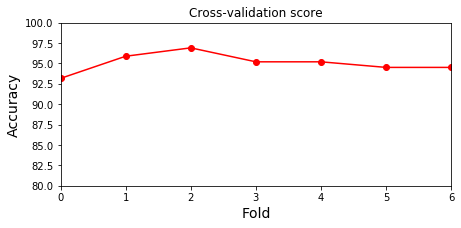

Average Accuracy: 95.06204791514999
Accuracy on Validation Data: 95.83333333333334
                    precision    recall  f1-score   support

            crouch       0.97      1.00      0.98        29
right arm extended       1.00      1.00      1.00        30
 left arm extended       0.93      0.93      0.93        30
  both arms lifted       0.93      0.90      0.92        31

          accuracy                           0.96       120
         macro avg       0.96      0.96      0.96       120
      weighted avg       0.96      0.96      0.96       120



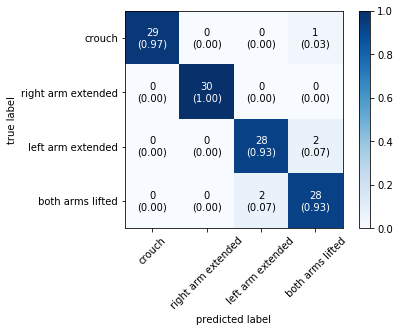

In [220]:
clf=model_nb()
avg_acc,acc=cv(clf,data,label,7)
pred=clf.predict(val_data)
result=calculateAccuracy(pred,val_label)
print('Accuracy on Validation Data:',result)
generateClassificationReport(pred,val_label)

### Create a Linear Gaussian Model Classifier and Test Performance

Fold: 1  Accuracy: 99.65870307167235
Fold: 2  Accuracy: 99.65753424657534
Fold: 3  Accuracy: 99.31506849315068
Fold: 4  Accuracy: 99.65753424657534
Fold: 5  Accuracy: 99.65753424657534
Fold: 6  Accuracy: 99.31506849315068
Fold: 7  Accuracy: 99.31506849315068


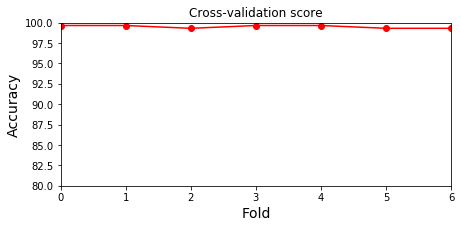

Average Accuracy: 99.5109301844072
Accuracy on Validation Data: 100.0
                    precision    recall  f1-score   support

            crouch       1.00      1.00      1.00        30
right arm extended       1.00      1.00      1.00        30
 left arm extended       1.00      1.00      1.00        30
  both arms lifted       1.00      1.00      1.00        30

          accuracy                           1.00       120
         macro avg       1.00      1.00      1.00       120
      weighted avg       1.00      1.00      1.00       120



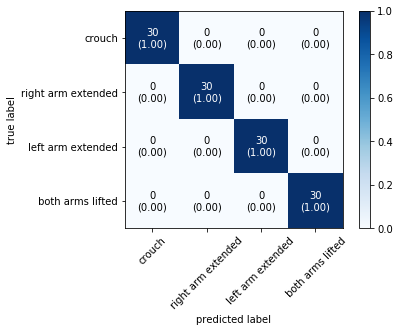

In [218]:

clf=model_lgm(nui_skeleton_conn)
avg_acc,acc=cv(clf,data,label,7)
pred=clf.predict(val_data)
result=calculateAccuracy(pred,val_label)
print('Accuracy on Validation Data:',result)
generateClassificationReport(pred,val_label)

### Compare with Validation Data

In [210]:
import scipy.io
import numpy as np

d = scipy.io.loadmat('data/validation_data.mat')

data_small        = d['data_small']
labels_small      = d['labels_small']
individuals_small = d['individuals_small'].squeeze()
train_indexes     = np.array(d['train_indexes'].squeeze(),dtype=bool)
test_indexes      = np.array(d['test_indexes'].squeeze(),dtype=bool)
model_n         = d['model_nb']
model_lg          = d['model_lg']
accur_lg          = d['accur_lg']
accur_nb          = d['accur_nb']

#Define NB model and compare with the provided result
NB=model_nb()
NB.train(data_small[:,:,train_indexes],labels_small[train_indexes][:])
pred_nb=NB.predict(data_small[:,:,test_indexes])
acc=calculateAccuracy(pred_nb,labels_small[test_indexes])
print("Expected model(NB) accuracy",accur_nb*100)
print("Our model(NB) accuracy",acc)

#Define LGM model and compare with the provided result
LGM=model_lgm(nui_skeleton_conn)
LGM.train(data_small[:,:,train_indexes],labels_small[train_indexes])
pred_lgm=LGM.predict(data_small[:,:,test_indexes])
acc=calculateAccuracy(pred_lgm,labels_small[test_indexes])
print("Expected model(LGM) accuracy",accur_lg*100)
print("Our model(LGM) accuracy",acc)



Expected model(NB) accuracy [[95.]]
Our model(NB) accuracy 95.0
Expected model(LGM) accuracy [[97.5]]
Our model(LGM) accuracy 97.5


Classification Report(NB) on Test Set 
                    precision    recall  f1-score   support

            crouch       0.90      1.00      0.95         9
right arm extended       1.00      1.00      1.00        10
 left arm extended       1.00      0.91      0.95        11
  both arms lifted       0.90      0.90      0.90        10

          accuracy                           0.95        40
         macro avg       0.95      0.95      0.95        40
      weighted avg       0.95      0.95      0.95        40



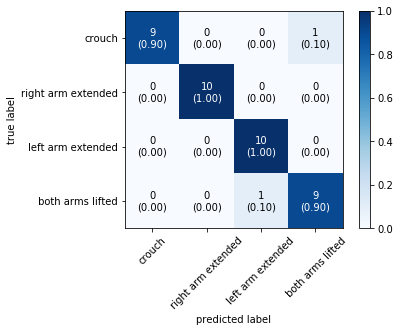

In [217]:
print('Classification Report(NB) on Test Set ')
generateClassificationReport(pred_nb,labels_small[test_indexes])

Classification Report(LGM) on Test Set 
                    precision    recall  f1-score   support

            crouch       1.00      1.00      1.00        10
right arm extended       1.00      1.00      1.00        10
 left arm extended       1.00      0.91      0.95        11
  both arms lifted       0.90      1.00      0.95         9

          accuracy                           0.97        40
         macro avg       0.97      0.98      0.97        40
      weighted avg       0.98      0.97      0.98        40



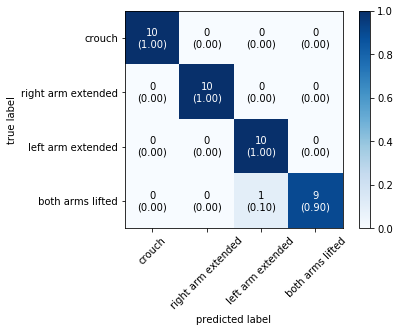

In [216]:
print('Classification Report(LGM) on Test Set ')
generateClassificationReport(pred_lgm,labels_small[test_indexes])